In [ ]:
import pyfolio as pf
import pandas as pd
pd.options.plotting.backend
from pathlib import Path
import os
import numpy as np
from matplotlib.dates import DateFormatter

Portfolio Performance in back testing

Start date,2015-01-02
End date,2020-12-31
Total months,71
,Backtest
Annual return,17.836%
Cumulative returns,167.534%
Annual volatility,21.585%
Sharpe ratio,0.87
Calmar ratio,0.51
Stability,0.93
Max drawdown,-35.183%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.18,2020-02-19,2020-03-23,2020-07-02,97
1,25.35,2018-10-03,2018-12-24,2019-04-23,145
2,15.87,2020-09-02,2020-10-28,2020-12-22,80
3,14.44,2015-07-20,2015-08-25,2016-03-16,173
4,11.70,2019-05-03,2019-06-03,2019-07-11,50


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


Top 10 long positions of all time,max
sid,
XLK,104.07%
XLB,101.45%
IYZ,100.06%
IYR,99.72%
XLV,99.64%
IWR,79.01%
XLP,2.64%
XLE,2.02%
VNQ,0.30%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
XLK,104.07%
XLB,101.45%
IYZ,100.06%
IYR,99.72%
XLV,99.64%
IWR,79.01%
XLP,2.64%
XLE,2.02%
VNQ,0.30%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,1409.00,1.00,1408.00
Percent profitable,0.65,0.00,0.65
Winning round_trips,918.00,0.00,918.00
Losing round_trips,488.00,0.00,488.00
Even round_trips,3.00,1.00,2.00


PnL stats,All trades,Short trades,Long trades
Total profit,$167534.20,$0.00,$167534.20
Gross profit,$527935.43,$0.00,$527935.43
Gross loss,$-360401.23,$0.00,$-360401.23
Profit factor,$1.46,$nan,$1.46
Avg. trade net profit,$118.90,$0.00,$118.99
Avg. winning trade,$575.09,$nan,$575.09
Avg. losing trade,$-738.53,$nan,$-738.53
Ratio Avg. Win:Avg. Loss,$0.78,$nan,$0.78
Largest winning trade,$17654.60,$0.00,$17654.60
Largest losing trade,$-23983.62,$0.00,$-23983.62


Duration stats,All trades,Short trades,Long trades
Avg duration,11 days 21:15:09.581973030,1 days,11 days 21:26:17.557528409
Median duration,6 days 00:00:00,1 days,6 days 00:00:00
Longest duration,89 days 00:00:00,1 days,89 days 00:00:00
Shortest duration,0 days 03:00:01,1 days,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.07%,0.00%,0.07%
Avg returns winning,0.36%,nan%,0.36%
Avg returns losing,-0.49%,nan%,-0.49%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.02%,nan%,0.02%
Median returns losing,-0.05%,nan%,-0.05%
Largest winning trade,10.91%,0.00%,10.91%
Largest losing trade,-12.29%,0.00%,-12.29%


Symbol stats,IWR,IYR,IYZ,SHY,VNQ,XLB,XLE,XLK,XLP,XLV
Avg returns all round_trips,0.51%,-0.11%,-0.06%,-0.01%,-0.54%,0.06%,-2.93%,0.08%,0.00%,0.00%
Avg returns winning,0.51%,nan%,0.06%,nan%,nan%,0.26%,nan%,0.46%,nan%,nan%
Avg returns losing,nan%,-0.11%,-0.18%,-0.01%,-0.54%,-0.32%,-2.93%,-0.65%,nan%,nan%
Median returns all round_trips,0.51%,-0.11%,-0.02%,-0.01%,-0.54%,0.00%,-2.93%,0.01%,0.00%,0.00%
Median returns winning,0.51%,nan%,0.04%,nan%,nan%,0.02%,nan%,0.03%,nan%,nan%
Median returns losing,nan%,-0.11%,-0.17%,-0.01%,-0.54%,-0.03%,-2.93%,-0.07%,nan%,nan%
Largest winning trade,0.51%,-0.11%,0.16%,-0.01%,-0.54%,10.91%,-2.93%,9.57%,0.00%,0.00%
Largest losing trade,0.51%,-0.11%,-0.33%,-0.01%,-0.54%,-8.02%,-2.93%,-12.29%,0.00%,0.00%


Profitability (PnL / PnL total) per name,
symbol,
XLK,105.58%
IYZ,3.91%
IYR,1.09%
XLE,0.11%
VNQ,0.02%
XLP,0.01%
SHY,0.00%
XLV,-1.84%
XLB,-3.08%


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


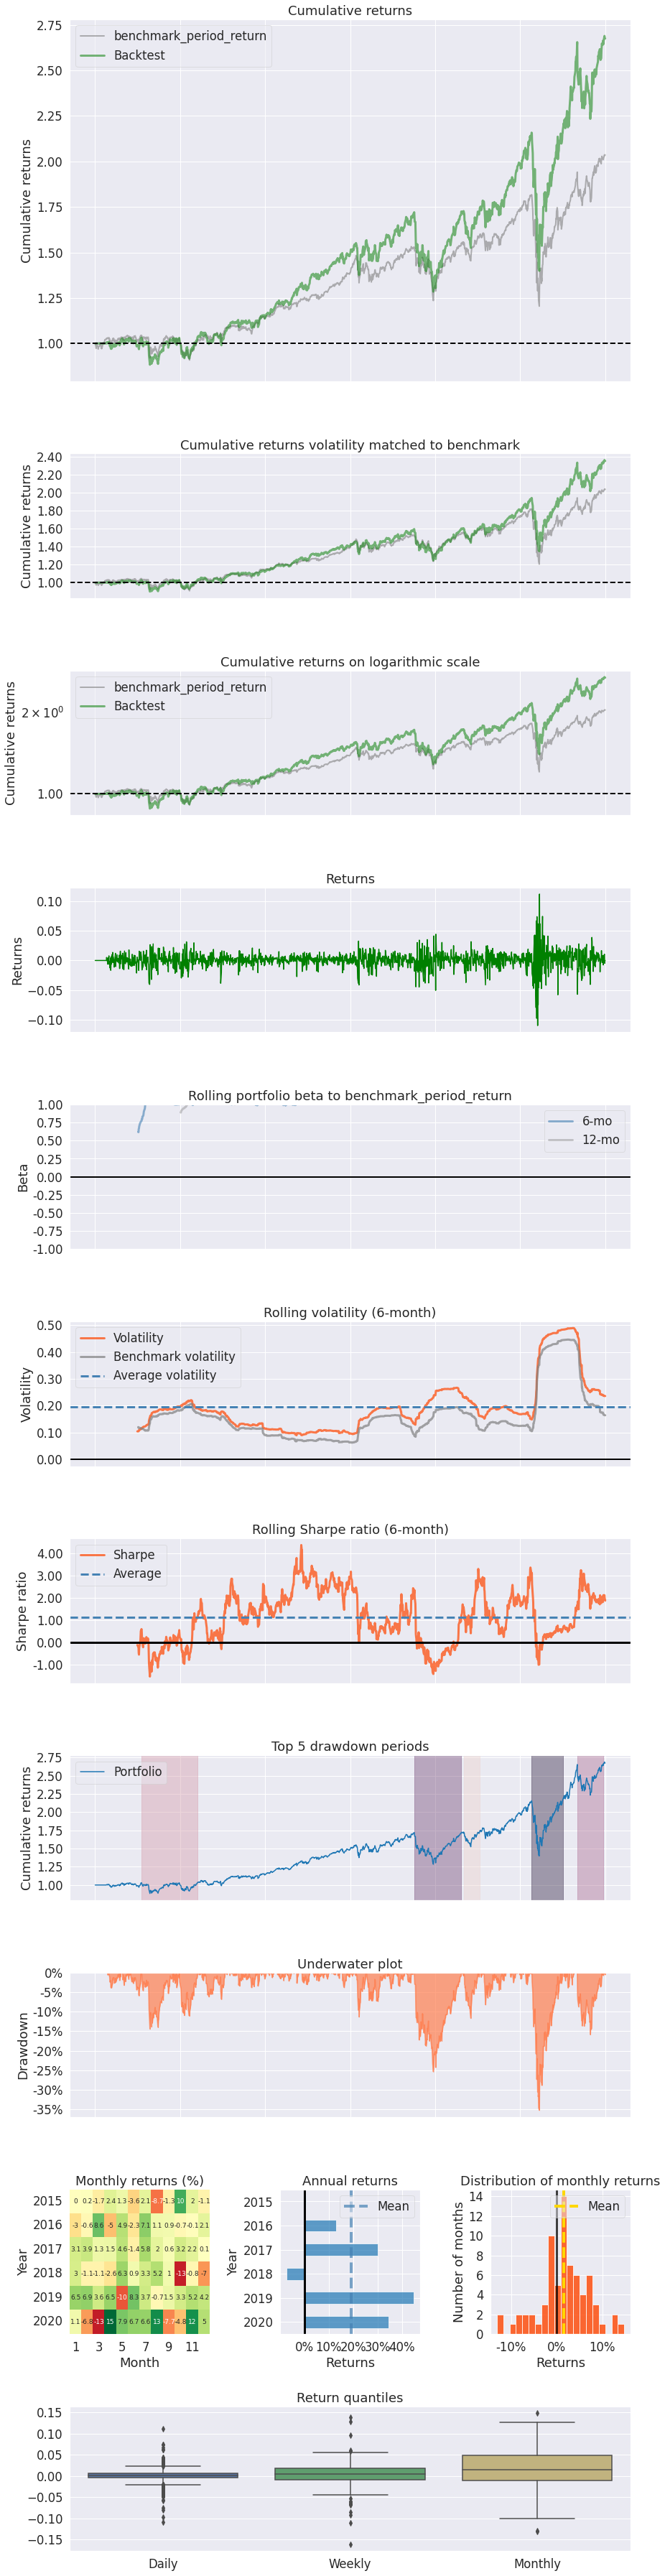

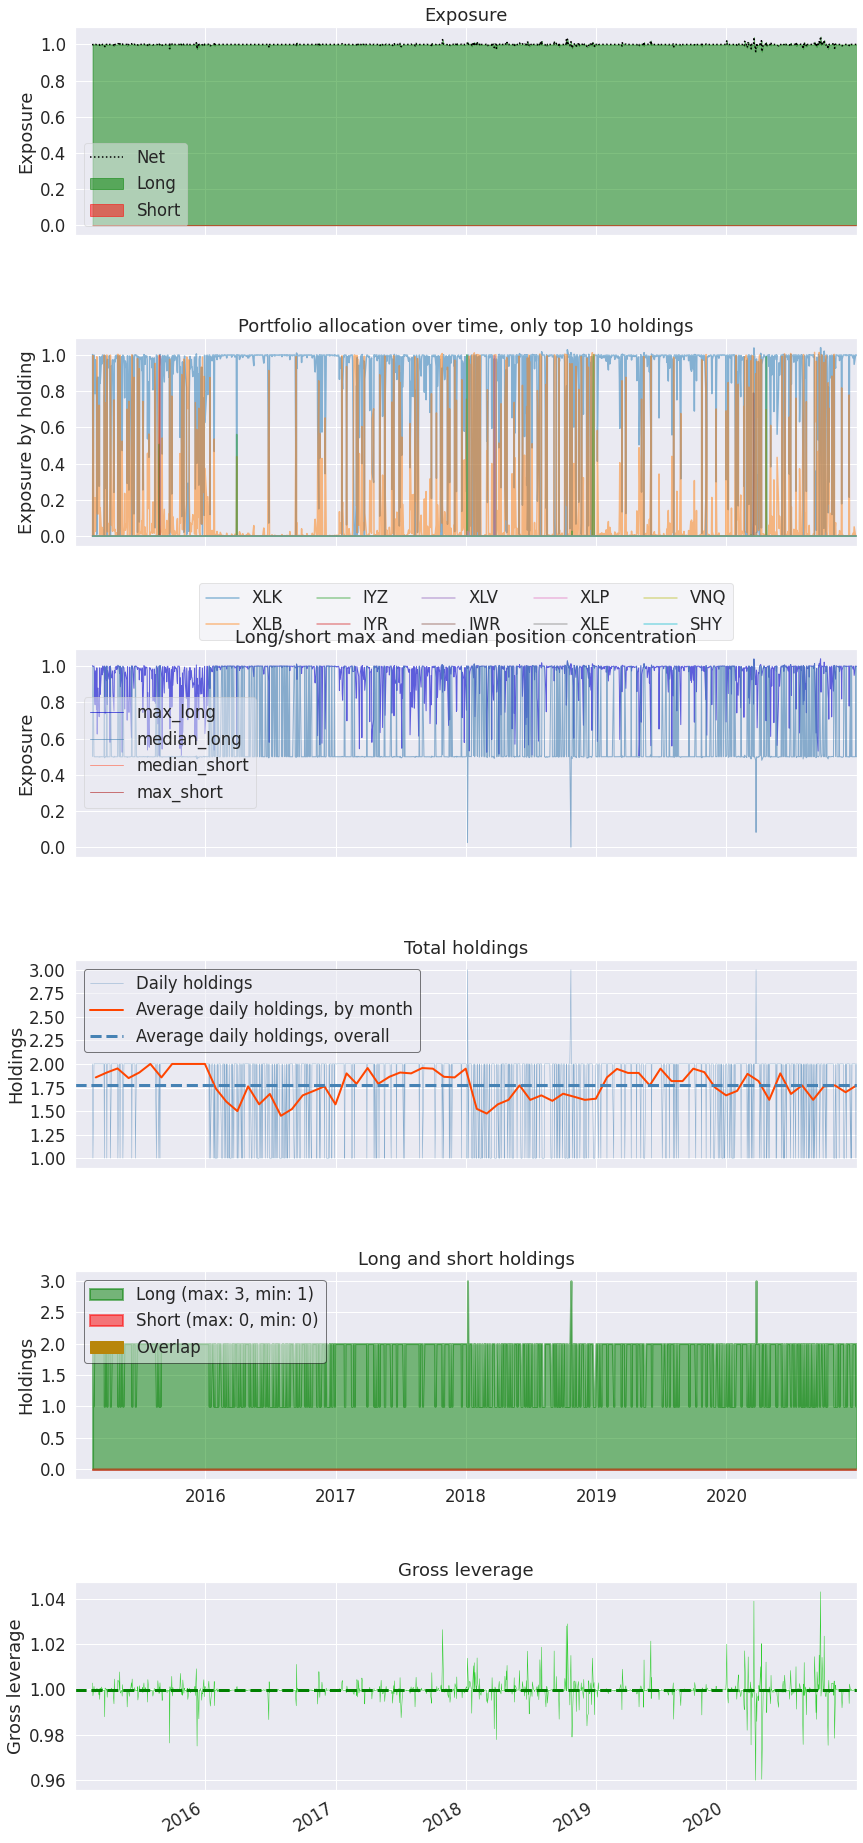

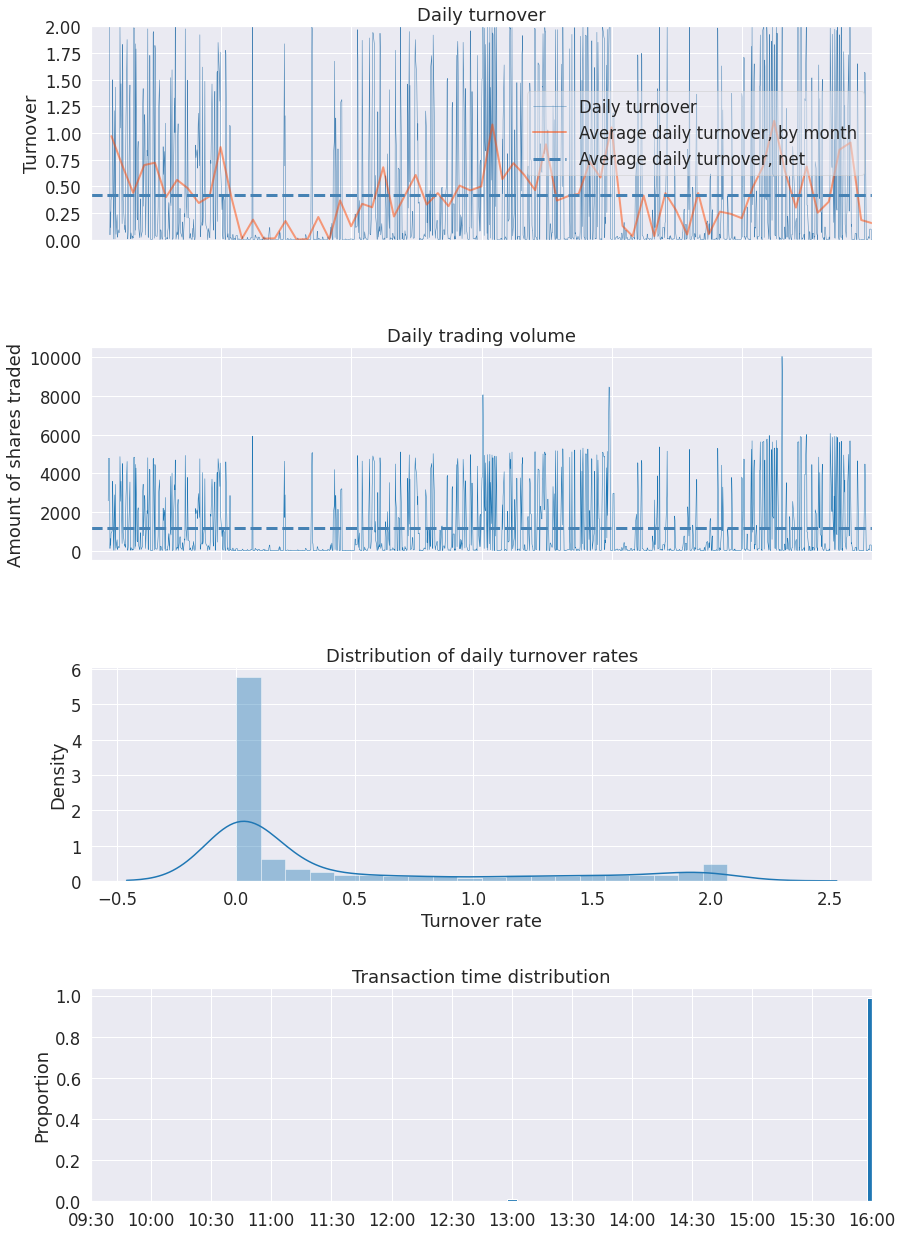

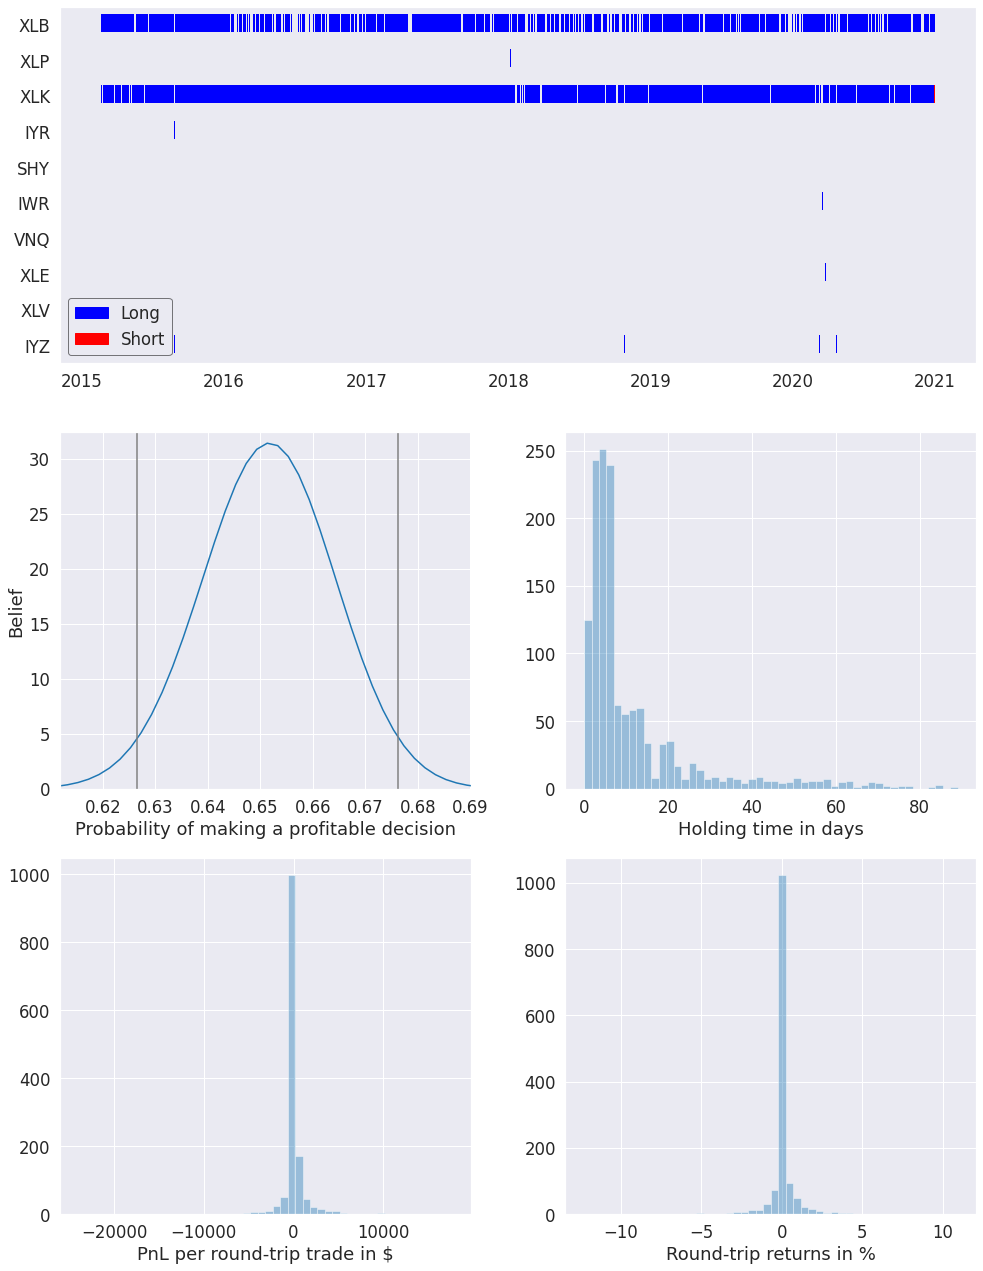

In [ ]:
results = pd.read_pickle(Path(Path.cwd(),'run_test_20211028_003158.pkl'))
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_period_return = results['benchmark_period_return']
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1
pf.create_full_tear_sheet(returns, positions=positions, benchmark_rets=daily_benchmark_returns,transactions=transactions,round_trips=True)

Monthly Average Portfolio Weights for Each Asset

In [ ]:
import plotly.express as px
positions_percent = pf.pos.get_percent_alloc(positions)
positions_percent.columns = positions_percent.columns.map(pf.utils.format_asset)

df_top_long, df_top_short, df_top_abs = pf.pos.get_top_long_short_abs(positions_percent)

df = positions_percent
df_plot = pd.melt(df.reset_index().resample('MS', on='index').mean().reset_index(), id_vars='index', value_vars=df.columns)
fig = px.bar(df_plot, x='index', y='value', color='sid',barmode = 'stack',labels={'index':'Year','value':'Percent'},title="Portfolio Weights")

fig.update_xaxes(
    dtick="M1",
    tickformat="%b %Y")

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="top",
    y=-0.45,
    xanchor="left",
    x=0.01
))
# fig.update_layout(hovermode="x")
fig.show()

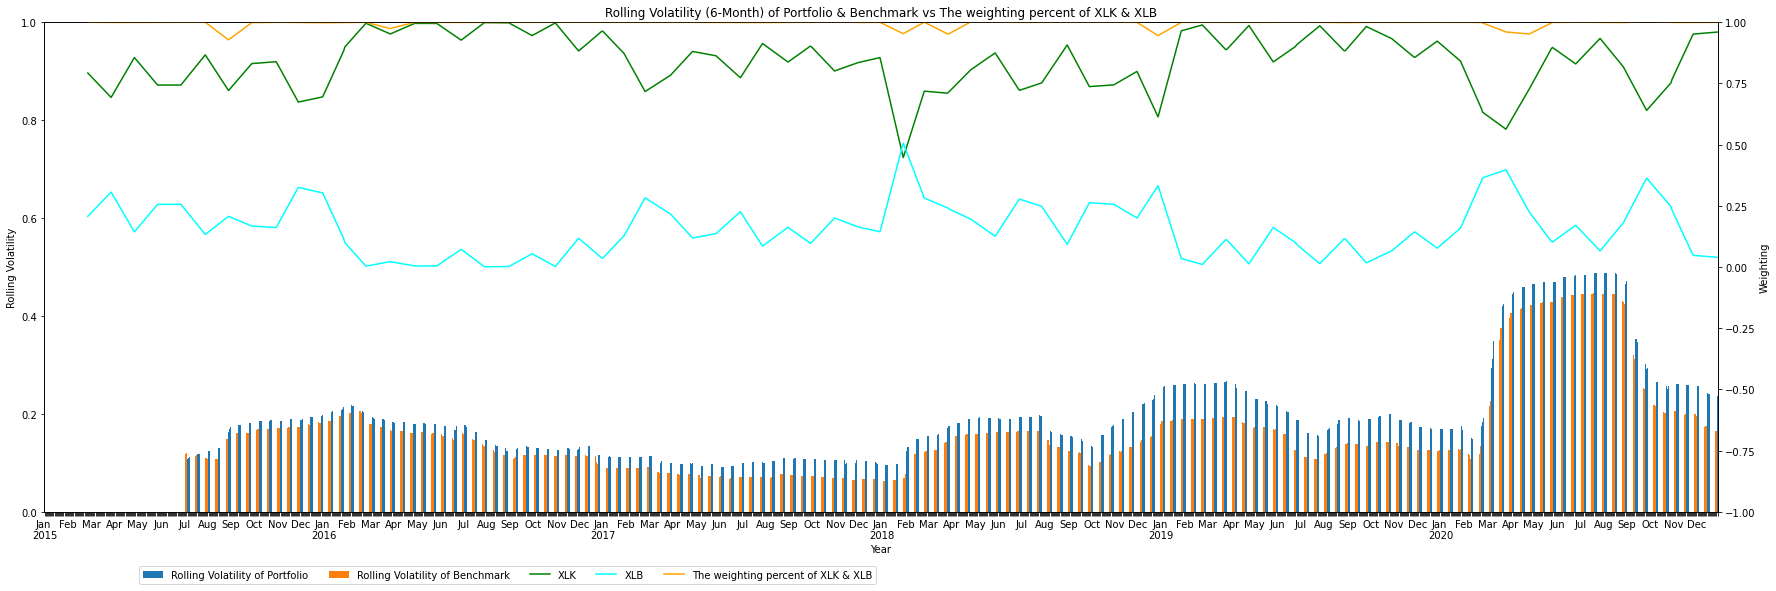

In [ ]:
# from scipy.interpolate import interp1d

positions_percent_major = positions_percent.loc[:,['XLK','XLB']]
positions_percent_major['sum_major_percent'] = positions_percent_major.loc[:,['XLK','XLB']].sum(axis=1)

positions_percent_monthly = positions_percent_major['sum_major_percent'].reset_index().resample('M', on='index').mean()
positions_percent_monthly.columns = ['sum_major_percent_monthly']
positions_percent_monthly['XLK_monthly'] = positions_percent_major.loc[:,['XLK']].reset_index().resample('M', on='index').mean()
positions_percent_monthly['XLB_monthly'] = positions_percent_major.loc[:,['XLB']].reset_index().resample('M', on='index').mean()

rolling_volatility_portfolio = pf.timeseries.rolling_volatility(returns,pf.utils.APPROX_BDAYS_PER_MONTH*6)
rolling_volatility_benchmark = pf.timeseries.rolling_volatility(daily_benchmark_returns,pf.utils.APPROX_BDAYS_PER_MONTH*6)

group_rolling_volatility = pd.concat([rolling_volatility_portfolio, rolling_volatility_benchmark], axis = 1)

ax = group_rolling_volatility.plot.bar(figsize=(30,20))
positions_percent_monthly['XLK_monthly'].reindex(positions_percent_monthly.index.union(rolling_volatility_portfolio.index)).interpolate().reindex(rolling_volatility_portfolio.index)\
.plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['green'])
positions_percent_monthly['XLB_monthly'].reindex(positions_percent_monthly.index.union(rolling_volatility_portfolio.index)).interpolate().reindex(rolling_volatility_portfolio.index)\
.plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['cyan'])
positions_percent_monthly['sum_major_percent_monthly'].reindex(positions_percent_monthly.index.union(rolling_volatility_portfolio.index)).interpolate().reindex(rolling_volatility_portfolio.index)\
.plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['orange'])

ax.set_ylim(0,1)
ax.right_ax.set_ylim(-1,1)
ax.set_title("Rolling Volatility (6-Month) of Portfolio & Benchmark vs The weighting percent of XLK & XLB",color='black')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
l1 = ['Rolling Volatility of Portfolio','Rolling Volatility of Benchmark']
l2 = ['XLK', 'XLB','The weighting percent of XLK & XLB']

ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.5, -0.1),ncol=len(l1+l2))
ax.set_xlabel('Year')
ax.set_ylabel('Rolling Volatility')
ax.right_ax.set_ylabel('Weighting')

ticklabels = ['']*len(group_rolling_volatility.index)
ticklabels[::21] = [item.strftime('%b \n%Y') if item.month==1 else item.strftime('%b') for idx,item in enumerate(group_rolling_volatility.index[::21])]
ax.set_xticks(range(group_rolling_volatility.index.size))
ax.set_xticklabels(ticklabels)
ax.figure.autofmt_xdate(rotation=0, ha='center');

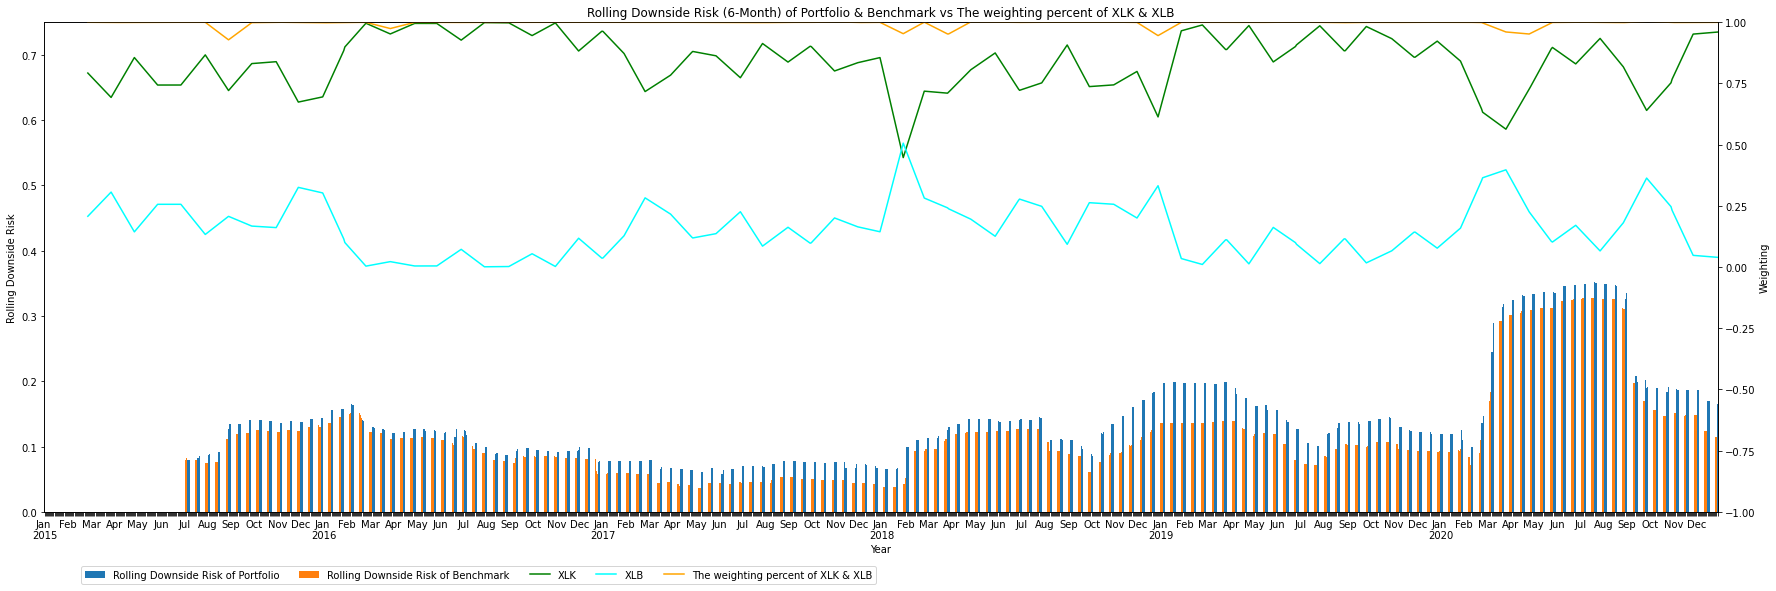

In [ ]:
# from scipy.interpolate import interp1d

positions_percent_major = positions_percent.loc[:,['XLK','XLB']]
positions_percent_major['sum_major_percent'] = positions_percent_major.loc[:,['XLK','XLB']].sum(axis=1)

positions_percent_monthly = positions_percent_major['sum_major_percent'].reset_index().resample('M', on='index').mean()
positions_percent_monthly.columns = ['sum_major_percent_monthly']
positions_percent_monthly['XLK_monthly'] = positions_percent_major.loc[:,['XLK']].reset_index().resample('M', on='index').mean()
positions_percent_monthly['XLB_monthly'] = positions_percent_major.loc[:,['XLB']].reset_index().resample('M', on='index').mean()

rolling_downside_deviation_portfolio = returns.rolling(pf.utils.APPROX_BDAYS_PER_MONTH*6).apply(pf.timeseries.downside_risk)
rolling_downside_deviation_benchmark = daily_benchmark_returns.rolling(pf.utils.APPROX_BDAYS_PER_MONTH*6).apply(pf.timeseries.downside_risk)

group_rolling_downside_deviation = pd.concat([rolling_downside_deviation_portfolio, rolling_downside_deviation_benchmark], axis = 1)

ax = group_rolling_downside_deviation.plot.bar(figsize=(30,20))
positions_percent_monthly['XLK_monthly'].reindex(positions_percent_monthly.index.union(rolling_volatility_portfolio.index)).interpolate().reindex(rolling_volatility_portfolio.index)\
.plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['green'])
positions_percent_monthly['XLB_monthly'].reindex(positions_percent_monthly.index.union(rolling_volatility_portfolio.index)).interpolate().reindex(rolling_volatility_portfolio.index)\
.plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['cyan'])
positions_percent_monthly['sum_major_percent_monthly'].reindex(positions_percent_monthly.index.union(rolling_volatility_portfolio.index)).interpolate().reindex(rolling_volatility_portfolio.index)\
.plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['orange'])

ax.set_ylim(0,0.75)
ax.right_ax.set_ylim(-1,1)
ax.set_title("Rolling Downside Risk (6-Month) of Portfolio & Benchmark vs The weighting percent of XLK & XLB",color='black')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
l1 = ['Rolling Downside Risk of Portfolio','Rolling Downside Risk of Benchmark']
l2 = ['XLK', 'XLB','The weighting percent of XLK & XLB']

ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.5, -0.1),ncol=len(l1+l2))
ax.set_xlabel('Year')
ax.set_ylabel('Rolling Downside Risk')
ax.right_ax.set_ylabel('Weighting')

ticklabels = ['']*len(group_rolling_downside_deviation.index)
ticklabels[::21] = [item.strftime('%b \n%Y') if item.month==1 else item.strftime('%b') for idx,item in enumerate(group_rolling_volatility.index[::21])]
ax.set_xticks(range(group_rolling_downside_deviation.index.size))
ax.set_xticklabels(ticklabels)
ax.figure.autofmt_xdate(rotation=0, ha='center');

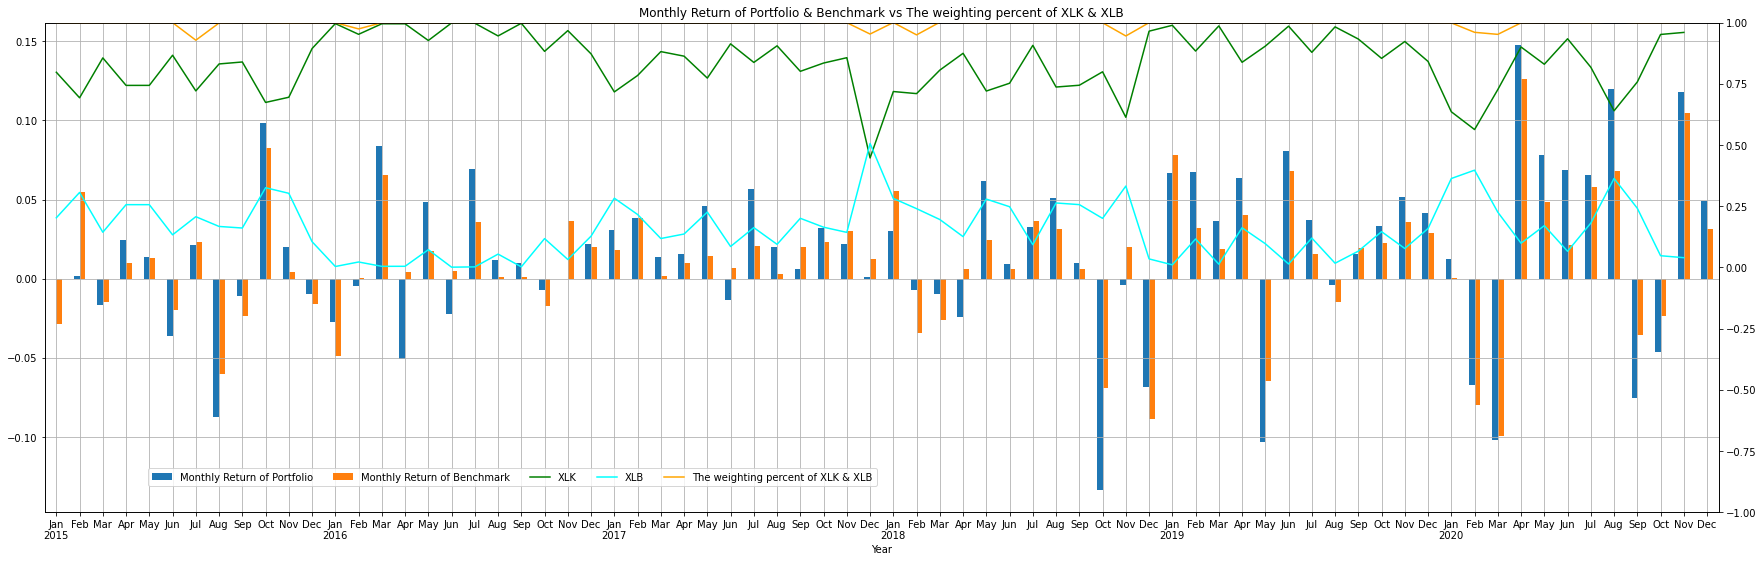

In [ ]:
# from scipy.interpolate import interp1d

positions_percent_major = positions_percent.loc[:,['XLK','XLB']]
positions_percent_major['sum_major_percent'] = positions_percent_major.loc[:,['XLK','XLB']].sum(axis=1)

positions_percent_monthly = positions_percent_major['sum_major_percent'].reset_index().resample('M', on='index').mean()
positions_percent_monthly.columns = ['sum_major_percent_monthly']
positions_percent_monthly['XLK_monthly'] = positions_percent_major.loc[:,['XLK']].reset_index().resample('M', on='index').mean()
positions_percent_monthly['XLB_monthly'] = positions_percent_major.loc[:,['XLB']].reset_index().resample('M', on='index').mean()

monthly_returns = returns.reset_index().resample('M', on='index').sum()
monthly_benchmark_returns = daily_benchmark_returns.reset_index().resample('M', on='index').sum()

group_monthly_returns = pd.concat([monthly_returns, monthly_benchmark_returns], axis = 1)

ax = group_monthly_returns.plot.bar(figsize=(30,20))
positions_percent_monthly['XLK_monthly'].plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['green'])
positions_percent_monthly['XLB_monthly'].plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['cyan'])
positions_percent_monthly['sum_major_percent_monthly'].plot(figsize=(30,10),secondary_y=True,ax=ax,use_index=False,color=['orange'])
ax.right_ax.set_ylim(-1,1)
ax.set_title("Monthly Return of Portfolio & Benchmark vs The weighting percent of XLK & XLB",color='black')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax.right_ax.get_legend_handles_labels()
l1 = ['Monthly Return of Portfolio','Monthly Return of Benchmark']
l2 = ['XLK', 'XLB','The weighting percent of XLK & XLB']

ax.legend(h1+h2, l1+l2,bbox_to_anchor=(0.5, 0.1),ncol=len(l1+l2))
ax.set_xlabel('Year')

ax.set_xticks(range(group_monthly_returns.index.size))
ax.set_xticklabels([ts.strftime('%b\n%Y') if ts.year != group_monthly_returns.index[idx-1].year
                    else ts.strftime('%b') for idx, ts in enumerate(group_monthly_returns.index)])
ax.grid(True)
ax.figure.autofmt_xdate(rotation=0, ha='center');